In [1]:
#Google API
from googleapiclient.discovery import build

In [2]:
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate #convert youtube duration to seconds

In [3]:
#Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
#NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to C:\Users\KAREN J
[nltk_data]     FERNANDES\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
api_key = 'GOOGLE API KEY HERE'

In [6]:
#channel ids
channel_ids = ['UChBEbMKI1eCcejTtmI32UEw']

In [7]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
  api_service_name, api_version, developerKey=api_key)

In [39]:
#basic channel stats
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    request = youtube.channels().list(
      part="snippet,contentDetails,statistics",
      id=','.join(channel_ids)
    )
    
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
               }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [9]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [10]:
channel_stats

,channelName,subscribers,views,playlistId
0,Joshua Weissman,7380000,499,UUhBEbMKI1eCcejTtmI32UEw


In [11]:
playlist_id = 'UUhBEbMKI1eCcejTtmI32UEw'

#
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [12]:
video_ids = get_video_ids(youtube, playlist_id)

In [13]:
len(video_ids)

499

In [49]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [50]:
#get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,6k-9ZCRRiWc,Joshua Weissman,Insane Fried Chicken Sandwich w/@albert_cancook,,None,2023-01-20T16:00:03Z,390928,21870,None,351,PT24S,hd,false
1,IIhvj3MnKFg,Joshua Weissman,First A5 Wagyu The Ocky Way @Theockyway,,None,2023-01-18T16:00:10Z,923258,70555,None,539,PT42S,hd,false
2,ZRn8YElNwwk,Joshua Weissman,Secret Garlic Hack,,None,2023-01-17T16:00:31Z,630737,34085,None,378,PT25S,hd,false
3,UBAmz9Vd1mI,Joshua Weissman,MSG Butter,,None,2023-01-16T16:00:23Z,297792,20210,None,311,PT44S,hd,false
4,NYejGx_FOjQ,Joshua Weissman,My Fried Rice Vs. Gordon Ramsay’s Fried Rice,"Nasi Goreng is arguably the best fried rice, b...","[sat bawl pro, joshua weissman, Fried rice, fr...",2023-01-15T15:00:21Z,1055619,40603,None,2208,PT9M19S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,Jh5L5IsNLmI,Joshua Weissman,Parsley Stem Ginger Lemonade,Lemonade is one of those things that is near a...,"[lemonade, ginger, drinks, kids, summer, sprin...",2017-04-18T21:00:39Z,53900,1994,None,81,PT7M44S,hd,false
495,Z50WjPO2zmA,Joshua Weissman,Flourless Chocolate Chip Cookie Ice Cream Sand...,Make the most delicious cookie ice cream sandw...,"[cookies, gluten free, grain free, paleo, ice ...",2016-07-06T22:24:08Z,42212,830,None,45,PT1M22S,hd,false
496,q_yR4In1_iI,Joshua Weissman,The Best Flourless Chewy Chocolate Chunk Cookies,Here is a how-to on making the best chewy choc...,"[gluten free, paleo, chocolate, cookies, Choco...",2015-11-04T03:09:33Z,144721,3552,None,101,PT1M42S,hd,false
497,XiRtP9EKLuc,Joshua Weissman,How to Make Chemex Coffee,"Song used - Riptide by Vance Joy, buy it here:...","[chemex coffee, Chemex Coffeemaker (Brand), ho...",2015-01-12T22:52:17Z,85228,1953,None,82,PT3M32S,hd,false


In [51]:
len(video_df)

499

In [17]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,K6Sf-2cKE0s,Joshua Weissman,How to Make Classic Homemade Pasta 4 ways,If you've ever wanted to make fresh pasta at h...,"[pasta, homemade pasta, pasta from scratch, pa...",2018-09-29T15:30:00Z,1254146,30866,None,678,PT12M8S,hd,false
1,v_qHWgmsPrw,Joshua Weissman,The Easiest Cold Brew Ever: 2 Ways,You should be making cold brew from home inste...,"[cold brew, how to make cold brew, easy cold b...",2018-09-23T14:45:02Z,3784345,98544,None,1989,PT4M21S,hd,true
2,uPqzY8rZLZM,Joshua Weissman,How To Make Real Tonkotsu Ramen,"This is that real deal, traditional tonkotsu r...","[ramen, how to make ramen, traditional tonkots...",2018-09-14T17:08:35Z,5157202,126650,None,4838,PT10M57S,hd,false
3,Gax5aw4RT20,Joshua Weissman,The Simplest French Toast (2 ways),French toast is one of the easiest (and most d...,"[french toast, french toast recipe, sourdough ...",2018-09-07T21:14:50Z,410892,16383,None,449,PT6M9S,hd,false
4,yMfOyJeIz8c,Joshua Weissman,How To Make Homemade Sourdough Pizza,A classic(ish) Neopolitan pizza margherita mad...,"[neopolitan pizza, pizza margherita, pizza rec...",2018-09-01T16:30:00Z,1696954,29254,None,914,PT12M42S,hd,false


In [18]:
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()

            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
        
        except: 
                # When error occurs - most likely because comments are disabled on a video
                print('Could not get comments for video ' + video_id)

    return pd.DataFrame(all_comments)

In [19]:
#get comment details
comments_df = get_comments_in_videos(youtube, video_ids)

In [20]:
len(comments_df)

499

In [21]:
comments_df.head()

,video_id,comments
0,6k-9ZCRRiWc,"[Bro this is so depressing, Josh used to be an..."
1,IIhvj3MnKFg,[I can't believe these wagyu lover comments. H...
2,ZRn8YElNwwk,[Guess I know what I am doing next time I'm in...
3,UBAmz9Vd1mI,[Shake your own butter with heavy whipping cre...
4,NYejGx_FOjQ,"[I always take my wok to poland, It would be e..."


In [52]:
# Write video data to CSV file for future references
video_df.to_csv('video_data.csv')
comments_df.to_csv('comments_data.csv')

## Data pre-processing

In [53]:
#checking for any null values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [54]:
#check datatypes
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [55]:
#converting to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [56]:
#check datatypes
video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [57]:
#publish day of week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [58]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName
0,6k-9ZCRRiWc,Joshua Weissman,Insane Fried Chicken Sandwich w/@albert_cancook,,None,2023-01-20 16:00:03+00:00,390928.0,21870.0,NaN,351.0,PT24S,hd,false,Friday
1,IIhvj3MnKFg,Joshua Weissman,First A5 Wagyu The Ocky Way @Theockyway,,None,2023-01-18 16:00:10+00:00,923258.0,70555.0,NaN,539.0,PT42S,hd,false,Wednesday
2,ZRn8YElNwwk,Joshua Weissman,Secret Garlic Hack,,None,2023-01-17 16:00:31+00:00,630737.0,34085.0,NaN,378.0,PT25S,hd,false,Tuesday
3,UBAmz9Vd1mI,Joshua Weissman,MSG Butter,,None,2023-01-16 16:00:23+00:00,297792.0,20210.0,NaN,311.0,PT44S,hd,false,Monday
4,NYejGx_FOjQ,Joshua Weissman,My Fried Rice Vs. Gordon Ramsay’s Fried Rice,"Nasi Goreng is arguably the best fried rice, b...","[sat bawl pro, joshua weissman, Fried rice, fr...",2023-01-15 15:00:21+00:00,1055619.0,40603.0,NaN,2208.0,PT9M19S,hd,false,Sunday


In [59]:
#converting duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [60]:
video_df[['durationSecs','duration']]

,durationSecs,duration
0,24.0,PT24S
1,42.0,PT42S
2,25.0,PT25S
3,44.0,PT44S
4,559.0,PT9M19S
...,...,...
494,464.0,PT7M44S
495,82.0,PT1M22S
496,102.0,PT1M42S
497,212.0,PT3M32S


In [61]:
#Add tag count
video_df['tag_count'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs,tag_count
0,6k-9ZCRRiWc,Joshua Weissman,Insane Fried Chicken Sandwich w/@albert_cancook,,None,2023-01-20 16:00:03+00:00,390928.0,21870.0,NaN,351.0,PT24S,hd,false,Friday,24.0,0
1,IIhvj3MnKFg,Joshua Weissman,First A5 Wagyu The Ocky Way @Theockyway,,None,2023-01-18 16:00:10+00:00,923258.0,70555.0,NaN,539.0,PT42S,hd,false,Wednesday,42.0,0
2,ZRn8YElNwwk,Joshua Weissman,Secret Garlic Hack,,None,2023-01-17 16:00:31+00:00,630737.0,34085.0,NaN,378.0,PT25S,hd,false,Tuesday,25.0,0
3,UBAmz9Vd1mI,Joshua Weissman,MSG Butter,,None,2023-01-16 16:00:23+00:00,297792.0,20210.0,NaN,311.0,PT44S,hd,false,Monday,44.0,0
4,NYejGx_FOjQ,Joshua Weissman,My Fried Rice Vs. Gordon Ramsay’s Fried Rice,"Nasi Goreng is arguably the best fried rice, b...","[sat bawl pro, joshua weissman, Fried rice, fr...",2023-01-15 15:00:21+00:00,1055619.0,40603.0,NaN,2208.0,PT9M19S,hd,false,Sunday,559.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,Jh5L5IsNLmI,Joshua Weissman,Parsley Stem Ginger Lemonade,Lemonade is one of those things that is near a...,"[lemonade, ginger, drinks, kids, summer, sprin...",2017-04-18 21:00:39+00:00,53900.0,1994.0,NaN,81.0,PT7M44S,hd,false,Tuesday,464.0,23
495,Z50WjPO2zmA,Joshua Weissman,Flourless Chocolate Chip Cookie Ice Cream Sand...,Make the most delicious cookie ice cream sandw...,"[cookies, gluten free, grain free, paleo, ice ...",2016-07-06 22:24:08+00:00,42212.0,830.0,NaN,45.0,PT1M22S,hd,false,Wednesday,82.0,29
496,q_yR4In1_iI,Joshua Weissman,The Best Flourless Chewy Chocolate Chunk Cookies,Here is a how-to on making the best chewy choc...,"[gluten free, paleo, chocolate, cookies, Choco...",2015-11-04 03:09:33+00:00,144721.0,3552.0,NaN,101.0,PT1M42S,hd,false,Wednesday,102.0,31
497,XiRtP9EKLuc,Joshua Weissman,How to Make Chemex Coffee,"Song used - Riptide by Vance Joy, buy it here:...","[chemex coffee, Chemex Coffeemaker (Brand), ho...",2015-01-12 22:52:17+00:00,85228.0,1953.0,NaN,82.0,PT3M32S,hd,false,Monday,212.0,26


## Data visualization

### Best Performing Videos

Text(0.5, 1.0, 'Best Performing Videos')

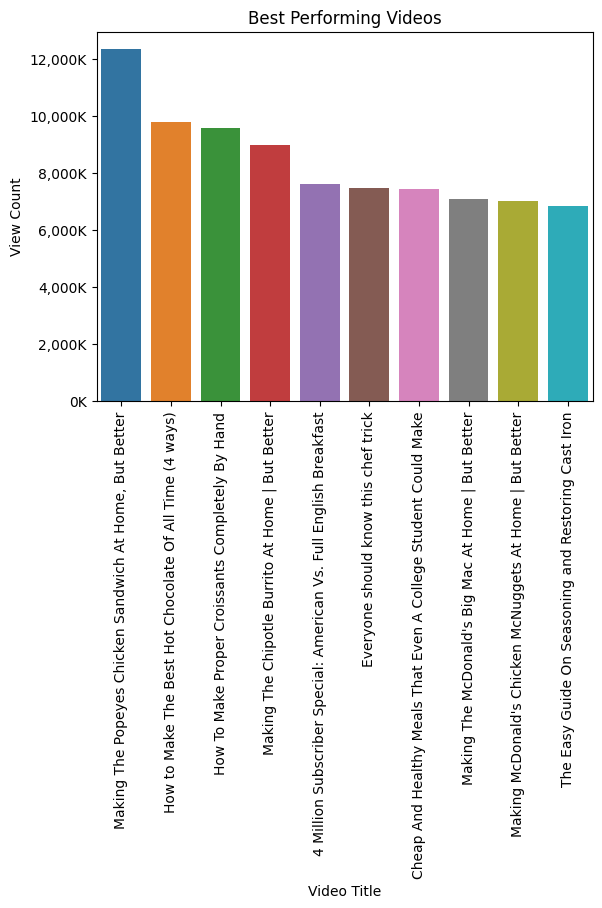

In [74]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.xlabel('Video Title')
plt.ylabel('View Count')
plt.title('Best Performing Videos')

### Worst Performing Videos

Text(0.5, 1.0, 'Worst Performing Videos')

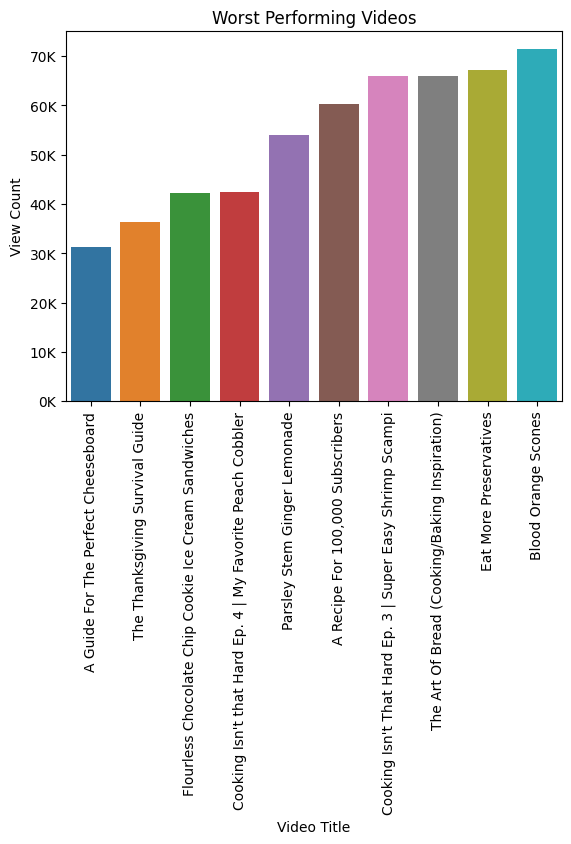

In [75]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.xlabel('Video Title')
plt.ylabel('View Count')
plt.title('Worst Performing Videos')

## View distribution per video

Text(0.5, 1.0, 'View Distribution')

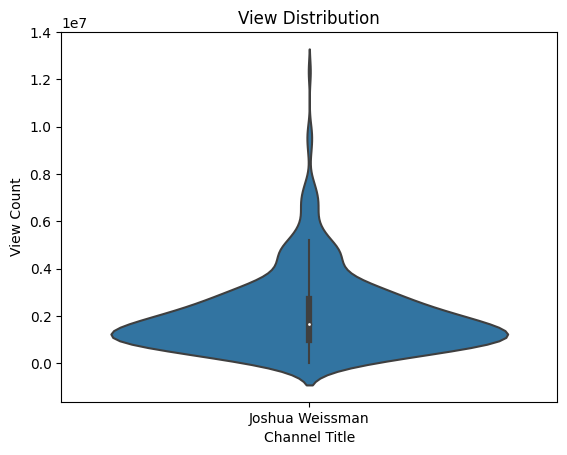

In [76]:
sns.violinplot(x ='channelTitle', y ='viewCount', data = video_df)
plt.ylabel('View Count')
plt.xlabel('Channel Title')
plt.title('View Distribution')

## Views vs Likes vs Comments

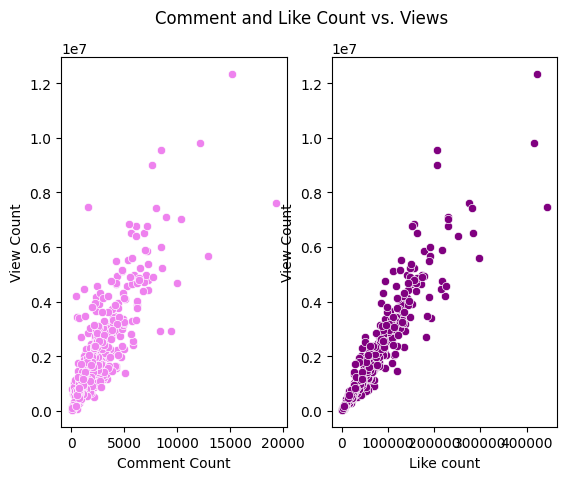

In [148]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0], color = 'violet')
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1], color = 'purple')
#plt.xticks(rotation=45)
fig.suptitle('Comment and Like Count vs. Views')
ax[0].set(xlabel='Comment Count', ylabel='View Count')
ax[1].set(xlabel='Like count', ylabel='View Count')

plt.show()

## Video Duration

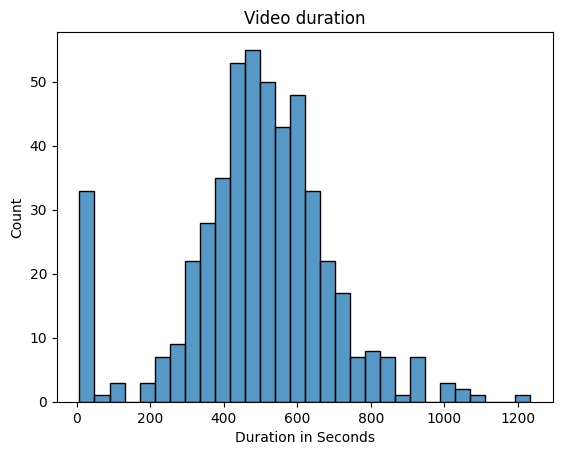

In [142]:
p = sns.histplot(data = video_df, x = 'durationSecs', bins = 30)
plt.title('Video duration')
plt.xlabel('Duration in Seconds')

plt.show()

## Word cloud for video title

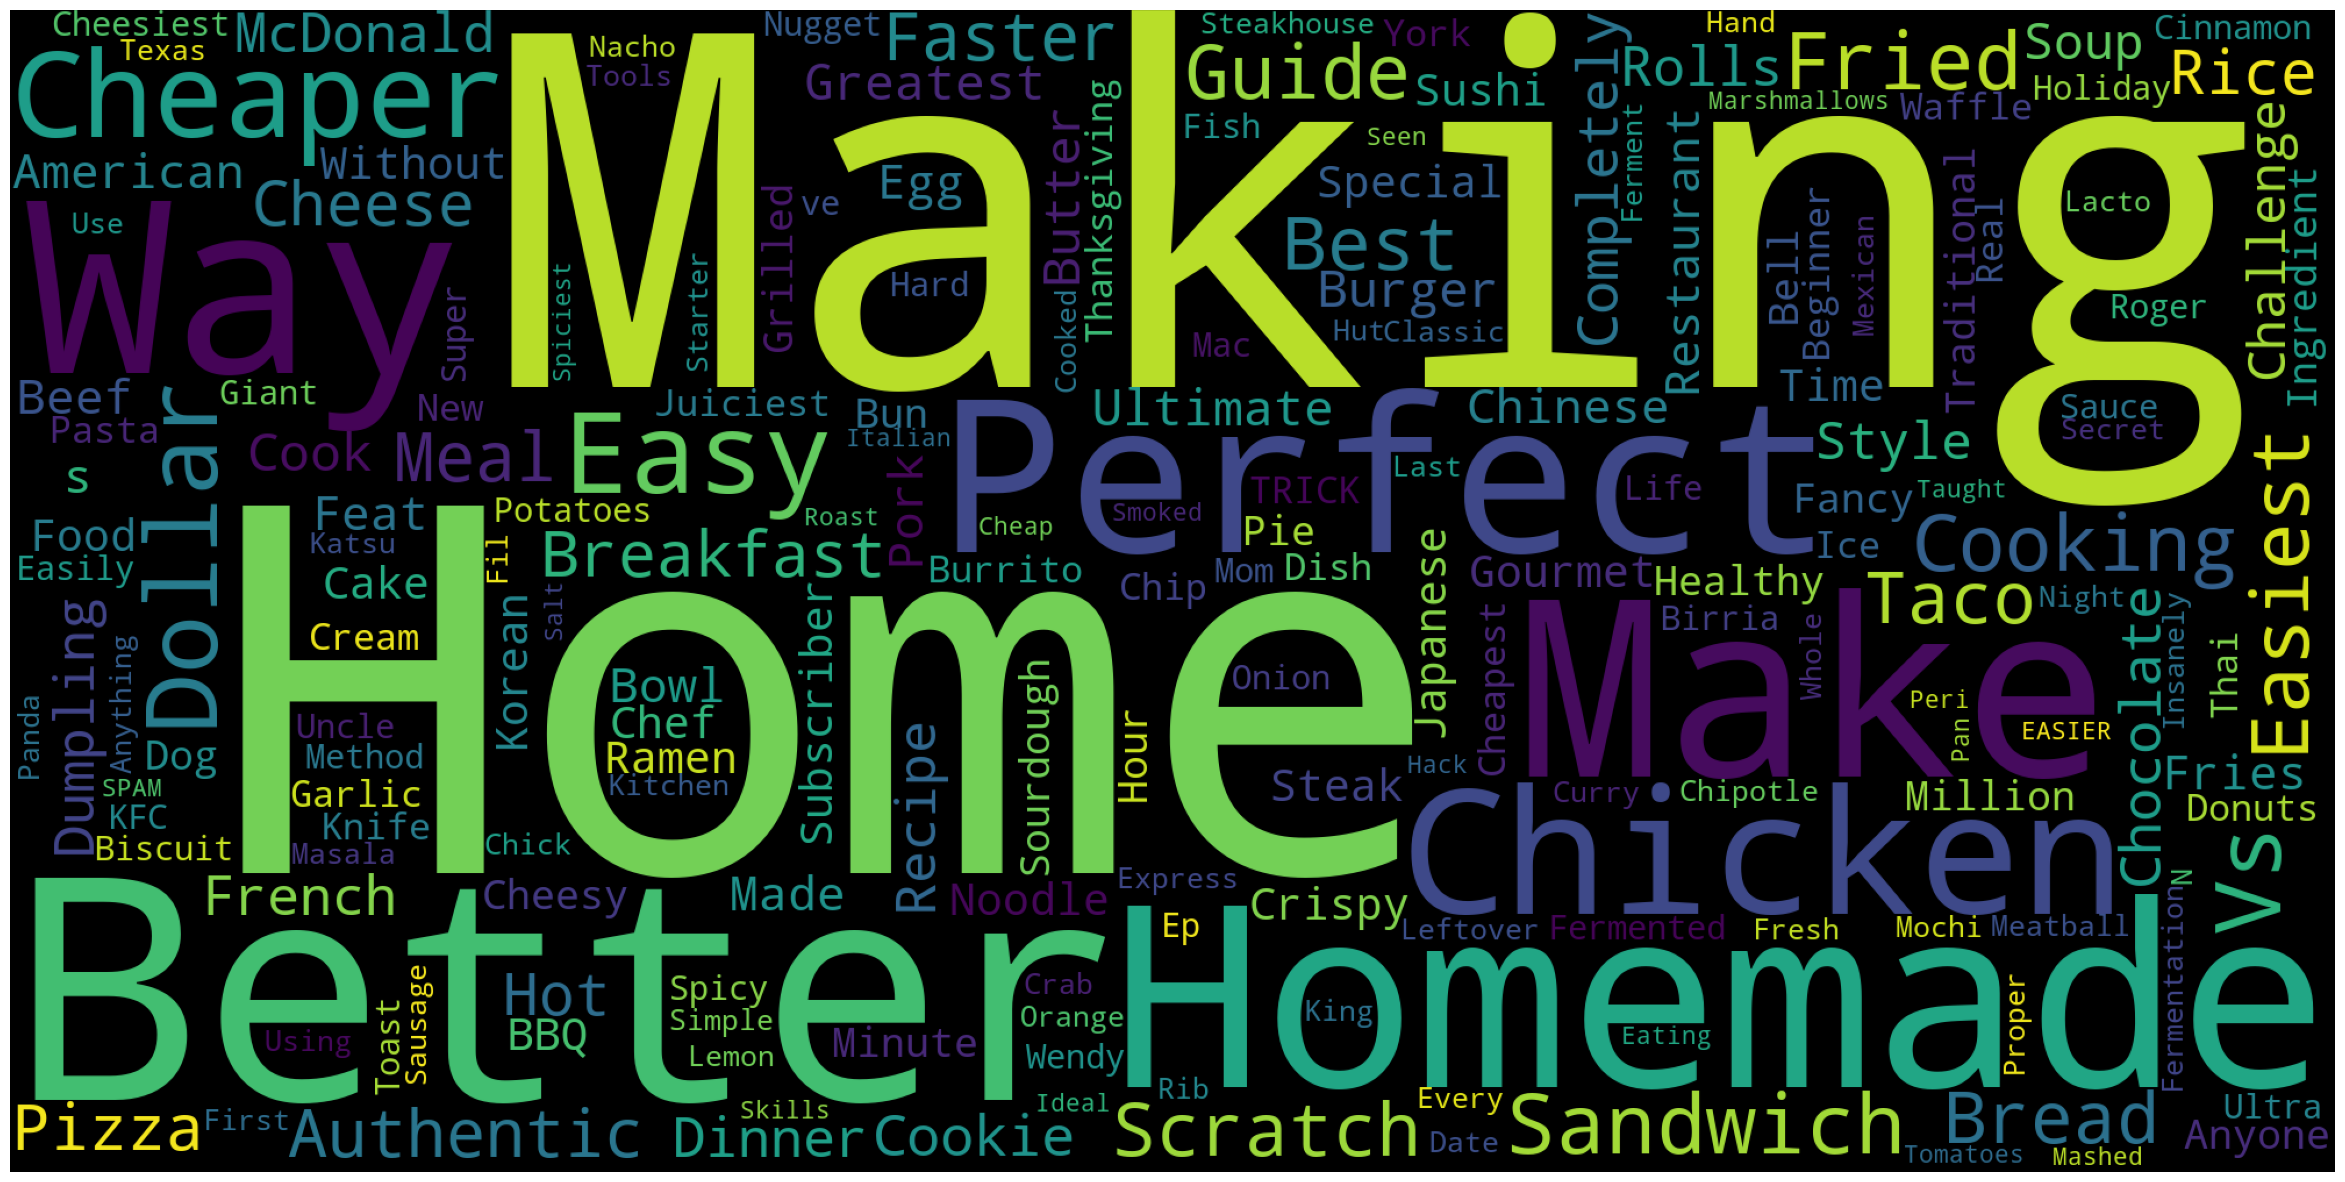

In [67]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Upload Schedule

<Figure size 5000x5000 with 0 Axes>

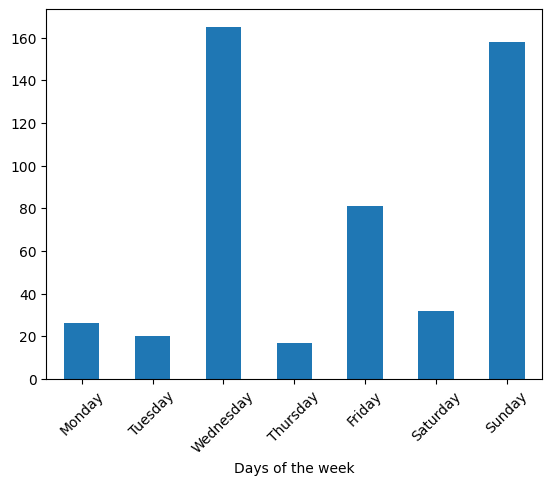

In [110]:
plt.figure(figsize=(50, 50))
day_df = pd.DataFrame(video_df['publishedDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishedDayName', rot=45)
plt.xlabel('Days of the week')
ax.get_legend().remove()

plt.show()